<a href="https://colab.research.google.com/github/boangri/neuraluniversity/blob/master/HW16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание №16 "Генетические алгоритмы. Подбор архитектуры НС" 22.11.2020

Борис Грибовский xinu@yandex.ru

## Библиотеки, подготовка данных

In [1]:
#Загружаем библиотеки

import pandas as pd # Пандас
import matplotlib.pyplot as plt # Отрисовка графиков
from tensorflow.keras import utils # Для to_categorical
import numpy as np # Numpy
from keras.optimizers import Adam # Оптимизатор
from keras.models import Sequential, Model # Два варианты моделей
from keras.layers import concatenate,Reshape, Input,Conv2DTranspose, Lambda, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM, MaxPooling1D, Activation, GlobalMaxPooling1D, UpSampling1D#Стандартные слои
from keras.losses import MAE
from google.colab import files # Загрузка файлов
from sklearn.preprocessing import StandardScaler, MinMaxScaler # Нормировщики
from keras.preprocessing.sequence import TimeseriesGenerator # Для генерации выборки временных рядов
import keras.backend as K
import random as random # Импортируем модель randim
import numpy as np # Импортируем библиотеку numpy
import matplotlib.pyplot as plt # Импортируем модуль pyplot библиотеки matplotlib для построения графиков
from PIL import Image # Импортируем одель Image для обработки изображений
import time
from tensorflow.keras.utils import plot_model
import seaborn as sns
sns.set_style('darkgrid')
# Статический вывод графики (графики отображаются в той ячейке, в которой используется plt.show())
%matplotlib inline

Базовый класс генетического алгоритма

In [2]:
class GA():
    def __init__(self, n, l, split=0.2, reverse=False, dtype=np.float32):
        """
        n: число ботов (размер популяции)
        l: размерность бота
        split: доля популяции, переходящая в новое поколение
        reverse: флаг True - ищем максимум функции потерь
        dtype: тип данных бота (float, int)
        """
        self.n = n
        self.l = l
        self.dtype = dtype
        self.nsurv = int(n*split)
        self.popul = np.zeros((self.n, self.l), dtype=dtype)
        self.best = np.zeros((self.nsurv, self.l), dtype=dtype)
        self.val = np.zeros(n)
        self.reverse = reverse

    def evaluate(self):
        for i in range(self.n):
            self.val[i] = self.loss(self.popul[i])

    def selectBest(self):
        self.evaluate()
        idx = sorted([i for i in range(self.n)], key=lambda i: self.val[i])
        self.best = self.popul[idx[:self.nsurv]].copy() 
        self.popul[:self.nsurv] = self.best
        return 

    def newGeneration(self):
        for i in range(self.nsurv, self.n):
            i1, i2 = np.random.choice(self.nsurv, 2, replace=False) # выбрали 2-х родителей
            self.child(i, i1, i2)
        return

    def mutation(self):
        return

    def evolution(self):
        self.selectBest()
        self.newGeneration()
        self.mutation()

    def child(self, i, i1, i2):
        for j in range(self.l):
            self.popul[i, j] = self.popul[i1, j] if np.random.rand() < 0.5 else self.popul[i2, j]
        return

    def loss(self, bot):
        return 0.0

# Класс строит график всего обучения, состоявшего из нескольких этапов.
class LearnHistory:
    def __init__(self):
        self.history = {'loss':[], 'val_loss': []}

    def append(self, history):
        self.history['loss'].extend(history.history['loss'])
        self.history['val_loss'].extend(history.history['val_loss'])

    def plot(self, ylim=None):
        ep = [i+1 for i in range(len(self.history['loss']))]
        plt.plot(ep, self.history['loss'], label='MSE на обучающем наборе')
        plt.plot(ep, self.history['val_loss'], label='MSE на проверочном наборе')
        plt.ylabel('Средняя ошибка')
        plt.xlabel('Эпоха')
        if ylim is not None:
            plt.ylim(0, ylim)
        plt.title('История обучения')
        plt.grid()
        plt.legend()
        plt.show()

In [3]:
# Функция рассчитываем результаты прогнозирования сети
# В аргументы принимает сеть (currModel) и проверочную выборку
# Выдаёт результаты предсказания predVal
# И правильные ответы в исходной размерности yValUnscaled (какими они были до нормирования)
def getPred(currModel, xVal, yVal, yScaler):
  # Предсказываем ответ сети по проверочной выборке
  # И возвращаем исходны масштаб данных, до нормализации
  predVal = yScaler.inverse_transform(currModel.predict(xVal))
  yValUnscaled = yScaler.inverse_transform(yVal)
  
  return (predVal, yValUnscaled)

# Функция визуализирует графики, что предсказала сеть и какие были правильные ответы
# start - точка с которой начинаем отрисовку графика
# step - длина графика, которую отрисовываем
# channel - какой канал отрисовываем
def showPredict(start, step, channel, predVal, yValUnscaled):
  plt.plot(figsize=(18,10))
  plt.plot(predVal[start:start+step, channel], 
           label='Прогноз')
  plt.plot(yValUnscaled[start:start+step, channel], 
           label='Базовый ряд')
  plt.xlabel('Время')
  plt.ylabel('Значение Close')
  plt.legend()
  plt.show()
  
# Функция расёта корреляции дух одномерных векторов
def correlate(a, b):
  # Рассчитываем основные показатели
  ma = a.mean() # Среднее значение первого вектора
  mb = b.mean() # Среднее значение второго вектора
  mab = (a*b).mean() # Среднее значение произведения векторов
  sa = a.std() # Среднеквадратичное отклонение первого вектора
  sb = b.std() # Среднеквадратичное отклонение второго вектора
  
  #Рассчитываем корреляцию
  val = 0
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val

# Функция рисуем корреляцию прогнозированного сигнала с правильным
# Смещая на различное количество шагов назад
# Для проверки появления эффекта автокорреляции
# channels - по каким каналам отображать корреляцию
# corrSteps - на какое количество шагов смещать сигнал назад для рассчёта корреляции
# showGraf - показываем график или нет
# returnData - возвращаем массивы автокорреляции или нет
def autoCorr(channels, corrSteps, predVal, yValUnscaled, showGraf = True, returnData = False):
  # Проходим по всем каналам
  for ch in channels:
    corr = [] # Создаём пустой лист, в нём будут корреляции при смезении на i рагов обратно
    yLen = yValUnscaled.shape[0] # Запоминаем размер проверочной выборки

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      corr.append(correlate(yValUnscaled[:yLen-i,ch], predVal[i:, ch]))

    own_corr = [] # Создаём пустой лист, в нём будут корреляции при смезении на i рагов обратно

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      own_corr.append(correlate(yValUnscaled[:yLen-i,ch], yValUnscaled[i:, ch]))

    # Отображаем график коррелций для данного шага
    if showGraf: #Если нужно показать график
      plt.plot(corr, label='предсказание на ' + str(ch+1) + ' шаг')
      plt.plot(own_corr, label='Эталон')

  if showGraf: #Если нужно показать график
    plt.xlabel('Время')
    plt.ylabel('Значение')
    plt.legend()
    plt.show()

  if returnData: #Если нужно вернуть массивы автокорреляции
    return corr, own_corr

In [4]:
# Считываем данные с помощью pandas
base_data = pd.read_csv('/content/drive/MyDrive/Базы/traff.csv',header=None)
data = base_data.iloc[:,1]

In [5]:
data = np.array(data) #Превращаем в numpy массив
for i in range(len(data)):
  data[i] = float(data[i].replace(',',''))

In [6]:
#Формируем параметры загрузки данных
xLen = 60     # Анализируем по 60 прошедшим точкам 
valLen = 300  # Используем 300 записей для проверки

trainLen = data.shape[0]-valLen # Размер тренировочной выборки

# Делим данные на тренировочную и тестовую выборки 
Train, Test = np.reshape(data[:trainLen],(-1,1)), np.reshape(data[trainLen+xLen+2:],(-1,1))

# Масштабируем данные (отдельно для X и Y), чтобы их легче было скормить сетке
Scaler = MinMaxScaler()
Scaler.fit(Train)
Train = Scaler.transform(Train)
Test = Scaler.transform(Test)

# Создаем генератор для обучения
trainDataGen = TimeseriesGenerator(Train, Train,             # в качестве параметров наши выборки
                               length=xLen, sampling_rate=1, # для каждой точки
                               batch_size=20)                # размер batch, который будем скармливать модели

# Создаем аналогичный генератор для валидации при обучении
testDataGen = TimeseriesGenerator(Test, Test,
                               length=xLen, sampling_rate=1,
                               batch_size=20)

# Создадим генератор проверочной выборки, из которой потом вытащим xVal, yVal для проверки
DataGen = TimeseriesGenerator(Test, Test,
                               length=xLen, sampling_rate=1,
                               batch_size=len(Test)) # Размер batch будет равен длине нашей выборки

xVal = []
yVal = []
for i in DataGen:
  xVal.append(i[0])
  yVal.append(i[1])

xVal = np.array(xVal)
yVal = np.array(yVal)

In [7]:
Train.shape, xVal.shape, yVal.shape

((795, 1), (1, 178, 60, 1), (1, 178, 1))

## Light задание

- Перепишите создание свёрточной сети с помощью ГА полностью своими руками
- Можно взять готовыми некоторые сложные функции
- Можно сделать другой формат свёрточной сети, не такой же, как в ноутбуке
- Можно подсматривать в базовый ноутбук, но не копировать код напрямую



Расширяем базовый класс ГА, реализовав специфичные для задачи методы

In [8]:
class netGA(GA):
    ranges = (
        (2, 5), # bot[0] - число LSTM units
        (1, 3), # bot[1] - число LSTM слоев
        (0, 3), # bot[2] - дропаут LSTM
        (5, 10), # bot[3] - размер 1-го полносвязного слоя
        (0, 3), # bot[4] - активация 1-го полносвязного слоя
        (0, 1), # bot[5] - нужна батч-нормализация?
        (0, 3), # bot[6] - дропаут 1-го полносвязного слоя
    )
        
    cache = {} # будем кэшировать точность бота, чтобы не пересчитывать ее заново. 

    def __init__(self, n, split=0.2, epochs=1, eps=0.1):
        self.l = len(self.ranges)
        super(netGA, self).__init__(n, self.l, split, dtype=np.uint8)
        self.n = n
        self.split = split
        self.epochs = epochs
        self.eps = eps
        for i in range(n):
            self.popul[i] = self.createRandomBot()

    def createRandomBot(self):
        bot = np.zeros((self.l,), dtype=np.uint8)
        for j in range(self.l):
            bot[j] = random.randint(self.ranges[j][0], self.ranges[j][1])
        return bot

    def loss(self, bot):
        hash = str(bot)
        if hash in self.cache.keys(): # точность этого бота уже подсчитывалась
            print('+', end='')
            return self.cache[hash]
        model = self.createModel(bot)
        history = model.fit(trainDataGen, epochs=self.epochs, validation_data=testDataGen, verbose=0)
        l = min(history.history['val_loss'])
        self.cache[hash] = l
        print('=', end='')
        return l

    def createModel(self, bot):
        act = ('linear', 'relu', 'sigmoid', 'tanh') # bot[4]
        inp = Input(shape=(None, 1))
        x = inp
        for n in range(bot[1]): # bot[1] - число LSTM слоев
            # x = LSTM(2**bot[0], dropout=0.1*bot[2], recurrent_dropout=0.1*bot[2], return_sequences=(n < (bot[1] - 1)))(x)
            x = LSTM(2**bot[0], return_sequences=(n < (bot[1] - 1)))(x if n > 0 else inp)
        x = Dense(2**bot[3])(x)
        if bot[5]:
            x = BatchNormalization()(x)
        x = Activation(act[bot[4]])(x)
        if bot[6]:
            x = Dropout(0.1*bot[6])(x)
        out = Dense(1, activation=act[0])(x)

        model = Model(inp, out)
        model.compile(optimizer=Adam(), loss='mse')

        return model
    
    def mutation(self):
        for i in range(self.nsurv, self.n):
            for j in range(self.l):
                if random.random() < self.eps:
                    self.popul[i][j] = random.randint(self.ranges[j][0], self.ranges[j][1])


Основной цикл ГА.

In [ ]:
%%time
n = 50 # размер популяции
n_gen = 6 # число поколений ГА
epochs = 10 # число эпох обучения
split = 0.4 # доля выживших
ga = netGA(n, epochs=epochs, split=split)
for ep in range(n_gen):
    ga.evolution()
    print(" %.4f"%ga.val[0], ga.popul[0])
bot = ga.popul[0]
model = ga.createModel(bot)
model.summary()
plot_model(model, show_shapes=True)
score = model.evaluate(testDataGen)
print (score)

============================================+===== 0.0146 [ 4  1  2 10  1  0  3]
++++++++++++++++++++================+===+=+======= 0.0099 [2 1 1 9 3 0 1]
++++++++++++++++++++===++=======+==+==========+=== 0.0097 [ 5  1  1 10  0  0  0]
++++++++++++++++++++==+================+======+=== 0.0096 [ 5  1  1 10  0  0  0]
++++++++++++++++++++===+=+++===+==========++=====+ 0.0096 [ 5  1  1 10  3  0  3]
+++++++++++++++++++++======+++=+=++=+++==+=======+ 0.0094 [ 5  1  1 10  3  0  3]
Model: "functional_585"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_293 (InputLayer)       [(None, None, 1)]         0         
_________________________________________________________________
lstm_464 (LSTM)              (None, 32)                4352      
_________________________________________________________________
dense_584 (Dense)            (None, 1024)              33792     
___________________________________

здесь + означает что данные брались из кэша, = означает расчет с обучением модели.

Лучший бот:

In [ ]:
bot = ga.popul[0]
print(bot)

[ 5  1  1 10  3  0  3]


Посмотрим, насколько вариативна точность полученной модели в зависимости от начальной инициализации.

In [ ]:
for i in range(5):
    model = ga.createModel(bot)
    history = model.fit(trainDataGen, epochs=10, validation_data=testDataGen, verbose=0)
    score = model.evaluate(testDataGen)
    print (score)

9/9 [==============================] - 0s 3ms/step - loss: 0.0101
0.010104288347065449
9/9 [==============================] - 0s 3ms/step - loss: 0.0104
0.010386675596237183
9/9 [==============================] - 0s 3ms/step - loss: 0.0107
0.010743383318185806
9/9 [==============================] - 0s 3ms/step - loss: 0.0096
0.009560431353747845
9/9 [==============================] - 0s 3ms/step - loss: 0.0102
0.010230816900730133


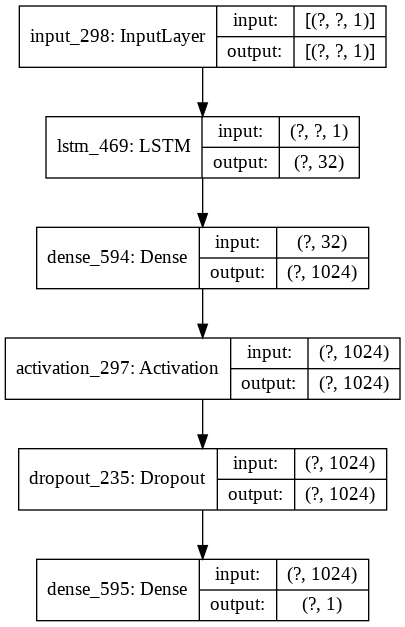

In [ ]:
plot_model(model, show_shapes=True)

Дообучим нашу модель

In [ ]:
history = model.fit(trainDataGen, epochs=30, validation_data=testDataGen)

Epoch 1/30
37/37 [==============================] - 0s 7ms/step - loss: 0.0055 - val_loss: 0.0112
Epoch 2/30
37/37 [==============================] - 0s 7ms/step - loss: 0.0060 - val_loss: 0.0095
Epoch 3/30
37/37 [==============================] - 0s 7ms/step - loss: 0.0056 - val_loss: 0.0094
Epoch 4/30
37/37 [==============================] - 0s 7ms/step - loss: 0.0054 - val_loss: 0.0094
Epoch 5/30
37/37 [==============================] - 0s 7ms/step - loss: 0.0060 - val_loss: 0.0097
Epoch 6/30
37/37 [==============================] - 0s 7ms/step - loss: 0.0057 - val_loss: 0.0089
Epoch 7/30
37/37 [==============================] - 0s 7ms/step - loss: 0.0052 - val_loss: 0.0115
Epoch 8/30
37/37 [==============================] - 0s 7ms/step - loss: 0.0053 - val_loss: 0.0085
Epoch 9/30
37/37 [==============================] - 0s 7ms/step - loss: 0.0052 - val_loss: 0.0077
Epoch 10/30
37/37 [==============================] - 0s 7ms/step - loss: 0.0054 - val_loss: 0.0073
Epoch 11/30
37/37 [

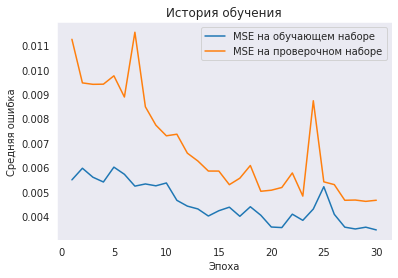

In [ ]:
lh = LearnHistory()
lh.append(history)
lh.plot()

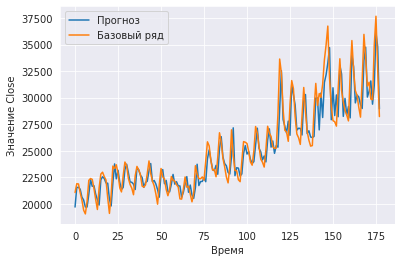

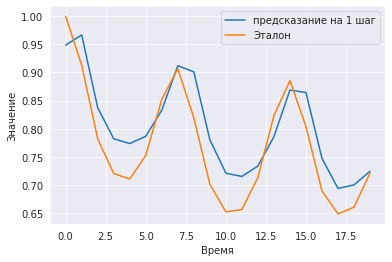

In [ ]:
# Прогнозируем данные текущей сетью
currModel = model #Выбираем текущую модель
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], Scaler) #Прогнозируем данные

# Отображаем графики
showPredict(0, 400, 0, predVal, yValUnscaled)
# Отображаем корреляцию
autoCorr([0], 20, predVal, yValUnscaled)

### ВЫВОД

ГА искал наилучшую модель среди моделей с переменным числом LSTM слоев.
Пришлось отказаться от дропаутов внутри LSTM так как это не может считаться на GPU, а расчеты и так объемны.

Применил кэширование результатов ботов, поскольку обучение модели занимает  досточно много времени.
Применил ООП - общая часть ГА реализована в родительском классе (GA), специфические для данной задачи вещи реализованы в дочернем классе (netGA). 

Интересно, что ГА _упорно_ отвергает многослойные LSTM - модели (в данной задаче)

## PRO задание

### 1. Нарастите сложность свёрточной сети, которая генерируется
- Сделайте возможность бота создать любую последовательность слоёв в любом количестве
- Можно управлять вероятностью появления свёрточных слоёв, MaxPooling, BatchNormalization и Dropout (сделать разную вероятность)
- Можно жёстко настроить появление Flatten и полносвязные слои только в конце
- Полносвязные слои ГА также может генерить в любом количестве


### Сделайте своими руками довольно мощную свёрточную сеть для предсказания трафика. 


In [36]:
# Моя ручная мощная сверочная сеть:

inp = Input(shape=(xLen, 1))

x = inp
x = Conv1D(1024, 5, activation='linear')(x)
x = Flatten()(x)
x = Dense(512, activation='linear')(x)
# x = BatchNormalization()(x)
# x = Dropout(0.3)(x)
out = Dense(1, activation='linear')(x)

model0 = Model(inp, out)
model0.compile(optimizer=Adam(lr=1e-4), loss='mse')
model0.summary()
lh0 = LearnHistory()

Model: "functional_363"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_183 (InputLayer)       [(None, 60, 1)]           0         
_________________________________________________________________
conv1d_284 (Conv1D)          (None, 56, 1024)          6144      
_________________________________________________________________
flatten_180 (Flatten)        (None, 57344)             0         
_________________________________________________________________
dense_368 (Dense)            (None, 512)               29360640  
_________________________________________________________________
dense_369 (Dense)            (None, 1)                 513       
Total params: 29,367,297
Trainable params: 29,367,297
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
37/37 [==============================] - 0s 10ms/step - loss: 0.8690 - val_loss: 0.3652
Epoch 2/20
37/37 [==============================] - 0s 7ms/step - loss: 0.2256 - val_loss: 0.0528
Epoch 3/20
37/37 [==============================] - 0s 7ms/step - loss: 0.0899 - val_loss: 0.0069
Epoch 4/20
37/37 [==============================] - 0s 7ms/step - loss: 0.0145 - val_loss: 0.0068
Epoch 5/20
37/37 [==============================] - 0s 7ms/step - loss: 0.0053 - val_loss: 0.0065
Epoch 6/20
37/37 [==============================] - 0s 7ms/step - loss: 0.0061 - val_loss: 0.0050
Epoch 7/20
37/37 [==============================] - 0s 7ms/step - loss: 0.0051 - val_loss: 0.0048
Epoch 8/20
37/37 [==============================] - 0s 7ms/step - loss: 0.0098 - val_loss: 0.0243
Epoch 9/20
37/37 [==============================] - 0s 7ms/step - loss: 0.0385 - val_loss: 0.0272
Epoch 10/20
37/37 [==============================] - 0s 7ms/step - loss: 0.0064 - val_loss: 0.0035
Epoch 11/20
37/37 

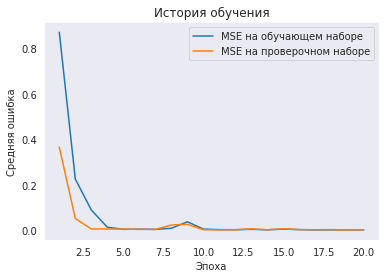

In [37]:
model0.compile(optimizer=Adam(lr=0.0001), loss='mse')
history = model0.fit(trainDataGen, epochs=20, validation_data=testDataGen)
lh0.append(history)
lh0.plot()

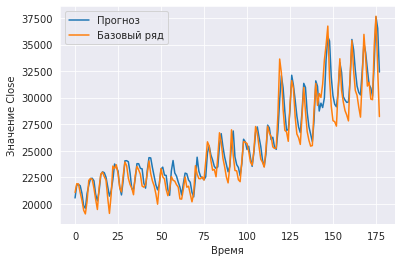

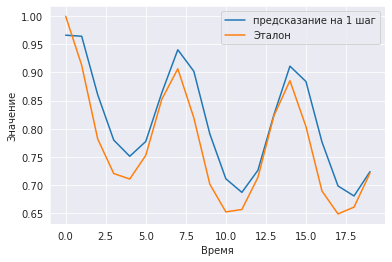

In [38]:
# Прогнозируем данные текущей сетью
currModel = model0 #Выбираем текущую модель
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], Scaler) #Прогнозируем данные

# Отображаем графики
showPredict(0, 400, 0, predVal, yValUnscaled)
# Отображаем корреляцию
autoCorr([0], 20, predVal, yValUnscaled)

### Добейтесь, чтобы ГА сделал точность на проверочной выше, чем у вашей сети


Возьмем за основу класс netGA, в нем достаточно переопределить метод создания модели и смысл параметров бота

In [22]:
class proGA(netGA):
    ranges = (
        (2, 10), # bot[0] - число Conv1D фильтров
        (1, 3), # bot[1] - число Conv1D слоев
        (1, 4), # bot[2] - размерность ядра свертки
        (0, 3), # bot[3] - активация Conv1D слоя
        (5, 10), # bot[4] - размер 1-го полносвязного слоя
        (0, 3), # bot[5] - активация 1-го полносвязного слоя
        (0, 1), # bot[6] - нужна батч-нормализация?
        (0, 3), # bot[7] - дропаут 1-го полносвязного слоя
    )

    def createModel(self, bot):
        act = ('linear', 'relu', 'sigmoid', 'tanh') 
        inp = Input(shape=(xLen, 1))
        x = inp
        for n in range(bot[1]): # bot[1] - число Conv1D слоев
            x = Conv1D(2**bot[0], (2*bot[2]+1,), activation=act[bot[3]])(x)
        x = Flatten()(x)
        x = Dense(2**bot[4], activation=act[bot[5]])(x)
        if bot[6]:
            x = BatchNormalization()(x)
        if bot[7]:
            x = Dropout(0.1*bot[7])(x)
        out = Dense(1)(x)

        model = Model(inp, out)
        model.compile(optimizer=Adam(lr=1e-4), loss='mse')

        return model

    def printModel(self, bot):
        act = ('linear', 'relu', 'sigmoid', 'tanh') 
        print("inp = Input(shape=(xLen, 1))");
        print("x = inp")
        for n in range(bot[1]): # bot[1] - число Conv1D слоев
            print("x = Conv1D(%d, (%d,), activation='%s')(x)" %(2**bot[0], 2*bot[2]+1, act[bot[3]]))
        print("x = Flatten()(x)")
        print("x = Dense(%d, activation='%s')(x)" % (2**bot[4], act[bot[5]]))
        if bot[6]:
            print("x = BatchNormalization()(x)")
        if bot[7]:
            print("x = Dropout(%.1f)(x)" % (0.1*bot[7]))
        print("out = Dense(1)(x)")

        print("model = Model(inp, out)")
        model.compile(optimizer=Adam(lr=1e-4), loss='mse')



In [23]:
%%time
n = 50 # размер популяции
n_gen = 6 # число поколений ГА
epochs = 10 # число эпох обучения
split = 0.4 # доля выживших
ga = proGA(n, epochs=epochs, split=split)
for ep in range(n_gen):
    ga.evolution()
    print(" %.4f"%ga.val[0], ga.popul[0])
bot = ga.popul[0]
model = ga.createModel(bot)
model.summary()
plot_model(model, show_shapes=True)
score = model.evaluate(testDataGen)
print (score)

================================================== 0.0359 [10  1  3  0  8  3  0  1]
++++++++++++++++++++===============+============== 0.0040 [10  1  1  3  8  0  0  0]
++++++++++++++++++++==============+=============== 0.0039 [10  1  3  3  8  3  0  1]
+++++++++++++++++++++=+=====++=============+====== 0.0033 [10  1  3  3  8  3  0  1]
++++++++++++++++++++=========+=++=+=+=======+====+ 0.0033 [10  1  3  3  8  3  0  1]
++++++++++++++++++++=+++==++==+==+=+=++====++===++ 0.0033 [10  1  1  0  9  3  0  0]
Model: "functional_357"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_179 (InputLayer)       [(None, 60, 1)]           0         
_________________________________________________________________
conv1d_280 (Conv1D)          (None, 58, 1024)          4096      
_________________________________________________________________
flatten_176 (Flatten)        (None, 59392)             0         
__________

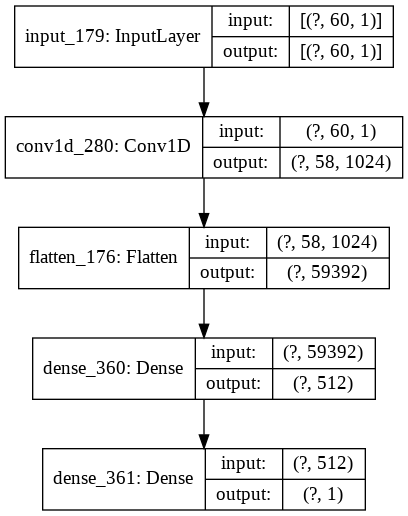

In [24]:
plot_model(model, show_shapes=True)

In [25]:
score = model.evaluate(testDataGen)
print(score)

9/9 [==============================] - 0s 3ms/step - loss: 0.4252
0.42518123984336853


In [27]:
ga = proGA(n, epochs=epochs, split=split)
print(bot)
ga.printModel(bot)

[10  1  1  0  9  3  0  0]
inp = Input(shape=(xLen, 1))
x = inp
x = Conv1D(1024, (3,), activation='linear')(x)
x = Flatten()(x)
x = Dense(512, activation='tanh')(x)
out = Dense(1)(x)
model = Model(inp, out)


In [28]:
inp = Input(shape=(xLen, 1))
x = inp
x = Conv1D(1024, (3,), activation='linear')(x)
x = Flatten()(x)
x = Dense(512, activation='tanh')(x)
out = Dense(1)(x)
model = Model(inp, out)
model.compile(optimizer=Adam(), loss='mse')
model.summary()

Model: "functional_359"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_180 (InputLayer)       [(None, 60, 1)]           0         
_________________________________________________________________
conv1d_281 (Conv1D)          (None, 58, 1024)          4096      
_________________________________________________________________
flatten_177 (Flatten)        (None, 59392)             0         
_________________________________________________________________
dense_362 (Dense)            (None, 512)               30409216  
_________________________________________________________________
dense_363 (Dense)            (None, 1)                 513       
Total params: 30,413,825
Trainable params: 30,413,825
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
37/37 [==============================] - 0s 8ms/step - loss: 0.0044 - val_loss: 0.0041
Epoch 2/10
37/37 [==============================] - 0s 7ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 3/10
37/37 [==============================] - 0s 7ms/step - loss: 0.0030 - val_loss: 0.0040
Epoch 4/10
37/37 [==============================] - 0s 7ms/step - loss: 0.0029 - val_loss: 0.0073
Epoch 5/10
37/37 [==============================] - 0s 7ms/step - loss: 0.0031 - val_loss: 0.0034
Epoch 6/10
37/37 [==============================] - 0s 7ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 7/10
37/37 [==============================] - 0s 7ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 8/10
37/37 [==============================] - 0s 7ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 9/10
37/37 [==============================] - 0s 7ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 10/10
37/37 [==============================] - 0s 7ms/step - loss: 0.0026 - val_loss: 0.0035


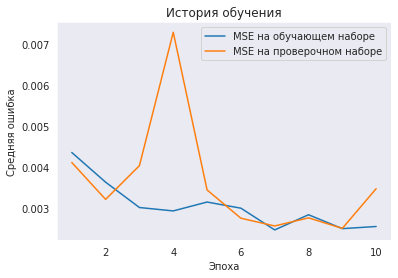

In [30]:
lh = LearnHistory()
history = model.fit(trainDataGen, epochs=epochs, validation_data=testDataGen, verbose=1)
lh.append(history)
lh.plot()

In [31]:
score = model.evaluate(testDataGen)
score

9/9 [==============================] - 0s 3ms/step - loss: 0.0035


0.0034762155264616013

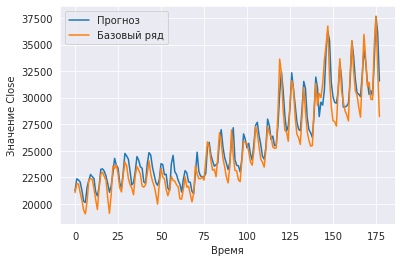

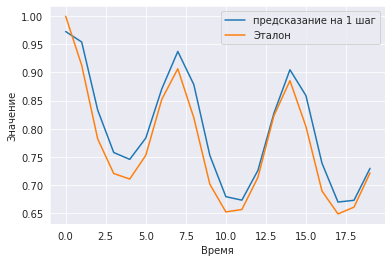

In [32]:
# Прогнозируем данные текущей сетью
currModel = model #Выбираем текущую модель
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], Scaler) #Прогнозируем данные

# Отображаем графики
showPredict(0, 400, 0, predVal, yValUnscaled)
# Отображаем корреляцию
autoCorr([0], 20, predVal, yValUnscaled)

Сравним точность двух сетей на тестовом наборе:

In [39]:
score0 = model0.evaluate(testDataGen)
score = model.evaluate(testDataGen)
print(score0, score)

9/9 [==============================] - 0s 3ms/step - loss: 0.0035
0.003610957181081176 0.0034762155264616013


ГА мог создавать сети с переменным числом Conv1D слоев, тем не менее в процессе эволюции лидировали однослойные сети.

Сеть, найденная ГА, показала чуть лучше результат, чем созданная руками. Кстати ручная сеть соответствует боту 

[10  1  2  0  9  0  0  0]